# UNet implementation with complementary tools to try different approaches
Based on https://youtu.be/u1loyDCoGbE for implementation of U-net : https://arxiv.org/pdf/1505.04597.pdf

This notebook is the reference notebook of our implementation, and we will make copies of it, to test different small changes and compare their results.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import cv2 as cv
import time

In [2]:
env = "colab" # local or colab
train_or_load = "train" # train or load : Are we training a model, or just loading a pretrained one ?

In [3]:
#Google Colab specifics
if env == "colab":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !cp "/content/drive/MyDrive/helpers.py" .
    imgs_names = glob.glob( '/content/drive/MyDrive/th_analysedimages/*.tif')
    labels_names = glob.glob('/content/drive/MyDrive/labels/*.png')

Mounted at /content/drive


In [4]:
#Local github project specifics
if env == "local":
    imgs_names = glob.glob( '/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/th_analysedimages/*.tif')
    labels_names = glob.glob('/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/th_csv_labels/png_masks_emb/*.png')
    !cp "/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/helpers.py" .

In [5]:
from helpers import png_to_mask, segment_dataset, compute_emb_surf_pred_error, confusion

imgs_names= sorted(imgs_names)
#imgs = [cv.imread(name, cv.IMREAD_UNCHANGED) for name in imgs_names[1]]
print(f"Found {len(imgs_names)} images")

labels_names= sorted(labels_names)
#labels = [png_to_mask(cv.imread(name, cv.IMREAD_UNCHANGED)) for name in labels_names]
print(f"Found {len(labels_names)} labels")

Found 357 images
Found 357 labels


UNet picture representation : 

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="300">

In [6]:
# Define the device to train on, if a GPU is available (ex when on Google Colab)
if not torch.cuda.is_available():
    print("Things will go much quicker if you enable a GPU, ex in Colab under 'Runtime / Change Runtime Type'")
else:
    #del model # only needed when re-running multiple times
    torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device is: {device}\n")

Selected device is: cuda



In [7]:
# UNet definitions
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # functions for going down the U
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.d_double_conv_1 = double_conv(1, 64)
        self.d_double_conv_2 = double_conv(64, 128)
        self.d_double_conv_3 = double_conv(128, 256)
        self.d_double_conv_4 = double_conv(256, 512)
        self.d_double_conv_5 = double_conv(512, 1024)
        
        # functions for going up the U
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)        
        self.u_double_conv_4 = double_conv(1024, 512)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.u_double_conv_3 = double_conv(512, 256)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.u_double_conv_2 = double_conv(256, 128)
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.u_double_conv_1 = double_conv(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)
        
    def forward(self, image):
        '''makes the 388x388 prediction with the model, image must be 572x572pixels'''
        
        # Going down the U
        d1 = self.d_double_conv_1(image) # first "level"
        # print(x1.size())
        x = self.max_pool_2x2(d1)
        d2 = self.d_double_conv_2(x) # second
        x = self.max_pool_2x2(d2)
        d3 = self.d_double_conv_3(x) # third
        x = self.max_pool_2x2(d3)
        d4 = self.d_double_conv_4(x) # fourth
        x = self.max_pool_2x2(d4)
        x = self.d_double_conv_5(x) # last layer (fifth) : no max pool
        # plt.imshow(x.detach().numpy()[0, 0, :, :])
        
        # Going up the U
        x = self.up_trans_4(x)
        d4 = crop_img(tensor=d4, target_tensor=x) #crop to copy
        x = self.u_double_conv_4(torch.cat([d4, x], 1))
        
        x = self.up_trans_3(x)
        d3 = crop_img(tensor=d3, target_tensor=x)
        x = self.u_double_conv_3(torch.cat([d3, x], 1))
        
        x = self.up_trans_2(x)
        d2 = crop_img(tensor=d2, target_tensor=x)
        x = self.u_double_conv_2(torch.cat([d2, x], 1))
        
        x = self.up_trans_1(x)
        d1 = crop_img(tensor=d1, target_tensor=x)
        x = self.u_double_conv_1(torch.cat([d1, x], 1))
        
        x = self.out(x)
        return x
        
        
    
# some functions so reduce redunduncy
def double_conv(nb_in_channels, nb_out_channels): # Used for every descending step
    conv = nn.Sequential(
        nn.Conv2d(nb_in_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(nb_out_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor): # Used for copy and crop between descending and ascending
    target_size = target_tensor.size()[2] # NB they are square so .size[2]=.size[3]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size #target is always smaller
    pix_crop = delta // 2
    return tensor[:, :, pix_crop:tensor_size-pix_crop, pix_crop:tensor_size-pix_crop]

In [8]:
# Training function
def train_model(model, img_pathnames, label_pathnames, criterion, optimizer, device, num_epochs=25, 
                disp_every_x_epoch = 1,
                disp_every_x_img = 1,
                max_seg_to_disp = 100, # NB 1 (and not 0) means the first segment is displayed
                disp_every_x_seg = 1):
    
    print("Starting the training on images !")
    model.train()
    for epoch in range(num_epochs):
        
        for image_i in range(len(img_pathnames)):
            image = cv.imread(img_pathnames[image_i], cv.IMREAD_UNCHANGED)
            label = png_to_mask(cv.imread(label_pathnames[image_i], cv.IMREAD_UNCHANGED))
            
            image_segments, label_segments = segment_dataset([image], [label])
            
            for segment_i in range(len(image_segments[:, 0, 0])):
                since = time.process_time() # For process monitoring
                img_seg = torch.tensor(image_segments[segment_i, :, :], requires_grad=True).view(1, 1, 572, 572).to(device).float()
                label_seg = torch.tensor(label_segments[segment_i, :, :].astype(float)).view(1, 388, 388).to(device).long()
                
                prediction = model(img_seg)
                loss = criterion(prediction, label_seg)
            
                # Compute the gradient
                optimizer.zero_grad()
                loss.backward()
                
                # Update the parameters of the model with a gradient step
                optimizer.step()
                            
                # Optionnaly display status during training
                if epoch%disp_every_x_epoch==0: 
                    if image_i==0 and segment_i==0:
                        print(f"\nEpoch {1+epoch}/{num_epochs}", end="")
                    if image_i%disp_every_x_img==0:
                        if segment_i==0:
                            print(f"\n|  Image {1+image_i}/{len(img_pathnames)} '{img_pathnames[image_i]}'", end="")
                        if segment_i<max_seg_to_disp and segment_i%disp_every_x_seg==0:
                            time_elapsed = time.process_time()-since

                            # Make new prediction so compare before and after step
                            new_prediction = model(img_seg)
                            new_loss = criterion(new_prediction, label_seg)
                            ori_lab_seg = label_seg.cpu().detach().numpy()[0,:,:].astype(int)
                            pred_lab_seg = torch.argmax(prediction, dim=1).cpu().detach().numpy()[0, :, :]

                            emb_surf_pred_error = compute_emb_surf_pred_error(ori_lab_seg, pred_lab_seg, print_values=False)
                            print(f"\n|  |  Segment {1+segment_i}/{len(image_segments[:, 0, 0])} : loss={loss} duration={int(time_elapsed)//60}m {int(time_elapsed%60)}s. Loss reduced {loss-new_loss}. Emb surf pred err={emb_surf_pred_error}%", end="")
                            
                            # # Also optionally print confusion values :
                            # print(f"\n|  |  Confusion values are :{confusion(ori_lab_seg, pred_lab_seg, data_type='numpy')}")

                            # # Also optionnaly print image segment, label and prediction
                            # _ , axs = plt.subplots(ncols=3, figsize=(40, 40))
                            # axs[0].set_title("Segment of original image")
                            # axs[0].imshow(img_seg.cpu().detach().numpy()[0,0,:,:])
                            # axs[1].set_title("Segment of original label")
                            # axs[1].imshow(label_seg.cpu().detach().numpy()[0,:,:])
                            # axs[2].set_title("Predicted label segment")
                            # axs[2].imshow(torch.argmax(prediction, dim=1).cpu().detach().numpy()[0,:,:])
                            # plt.show()
                elif epoch%disp_every_x_epoch==1 and image_i==0 and segment_i==0:
                    print("\n|  ...Next epochs, images & segments ", end="")
                else:
                    print(".", end="")

    print("\n\n Finished training")

In [12]:
# Actually training the model
if train_or_load == "train" :   
    learning_rate = 10e-4
    num_epochs=20
    model = UNet().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_model(model, imgs_names[:1], labels_names[:1], criterion, optimizer, device, num_epochs,
                disp_every_x_epoch = 10,
                disp_every_x_img = 100,
                max_seg_to_disp = 100, # NB 1 (and not 0) means the first segment is displayed
                disp_every_x_seg = 1)

Starting the training on images !

Epoch 1/20
|  Image 1/1 '/content/drive/MyDrive/th_analysedimages/Session1_flushed_1-fs-08_311.tif'
|  |  Segment 1/6 : loss=23.71830940246582 duration=0m 0s. Loss reduced -2475.42333984375. Emb surf pred err=-399200.0%
|  |  Segment 2/6 : loss=2596.244140625 duration=0m 0s. Loss reduced 2030.6536865234375. Emb surf pred err=2340.330685686497%
|  |  Segment 3/6 : loss=535.549072265625 duration=0m 0s. Loss reduced 529.55810546875. Emb surf pred err=4375.148632580262%
|  |  Segment 4/6 : loss=7.902297496795654 duration=0m 0s. Loss reduced -5.343337535858154. Emb surf pred err=-443100.0%
|  |  Segment 5/6 : loss=20.163354873657227 duration=0m 0s. Loss reduced 3.7677783966064453. Emb surf pred err=-678800.0%
|  |  Segment 6/6 : loss=8.669477462768555 duration=0m 0s. Loss reduced 3.599271774291992. Emb surf pred err=-357800.0%
|  ...Next epochs, images & segments .....................................................
Epoch 11/20
|  Image 1/1 '/content/drive

In [13]:
# Loading the pre-trained model
if train_or_load == "load":  
    model_name = "crossentr_adam_100ep_onlySegment0ofImage0"
    PATH = "/content/drive/MyDrive/savedmodels/" + model_name + ".pkl"

    if device == "cuda":
        map_to_device = "cuda:0"
    else:
        map_to_device = "cpu"

    model = UNet()

    checkpoint = torch.load(PATH)

    print(checkpoint['name'])
    print(checkpoint['description'])
    model.load_state_dict(checkpoint['model_state_dict'])
    # # If wanting to resume training :
    # optimizer = TheOptimizerClass(*args, **kwargs)
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    model.to(device)
    print("Model successfully loaded !")

Output shape : (1, 388, 388), max value=1, min=0, avg=0.019755021787650123
Original label 1s=3993, Predicted label 1s=2974
Emb surf pred err=-34.263618022864826% (target is 0%)
Confusion values are :(0.5336247478143914, 0.01630412685505184, 0.9836958731449481, 0.5336247478143914)


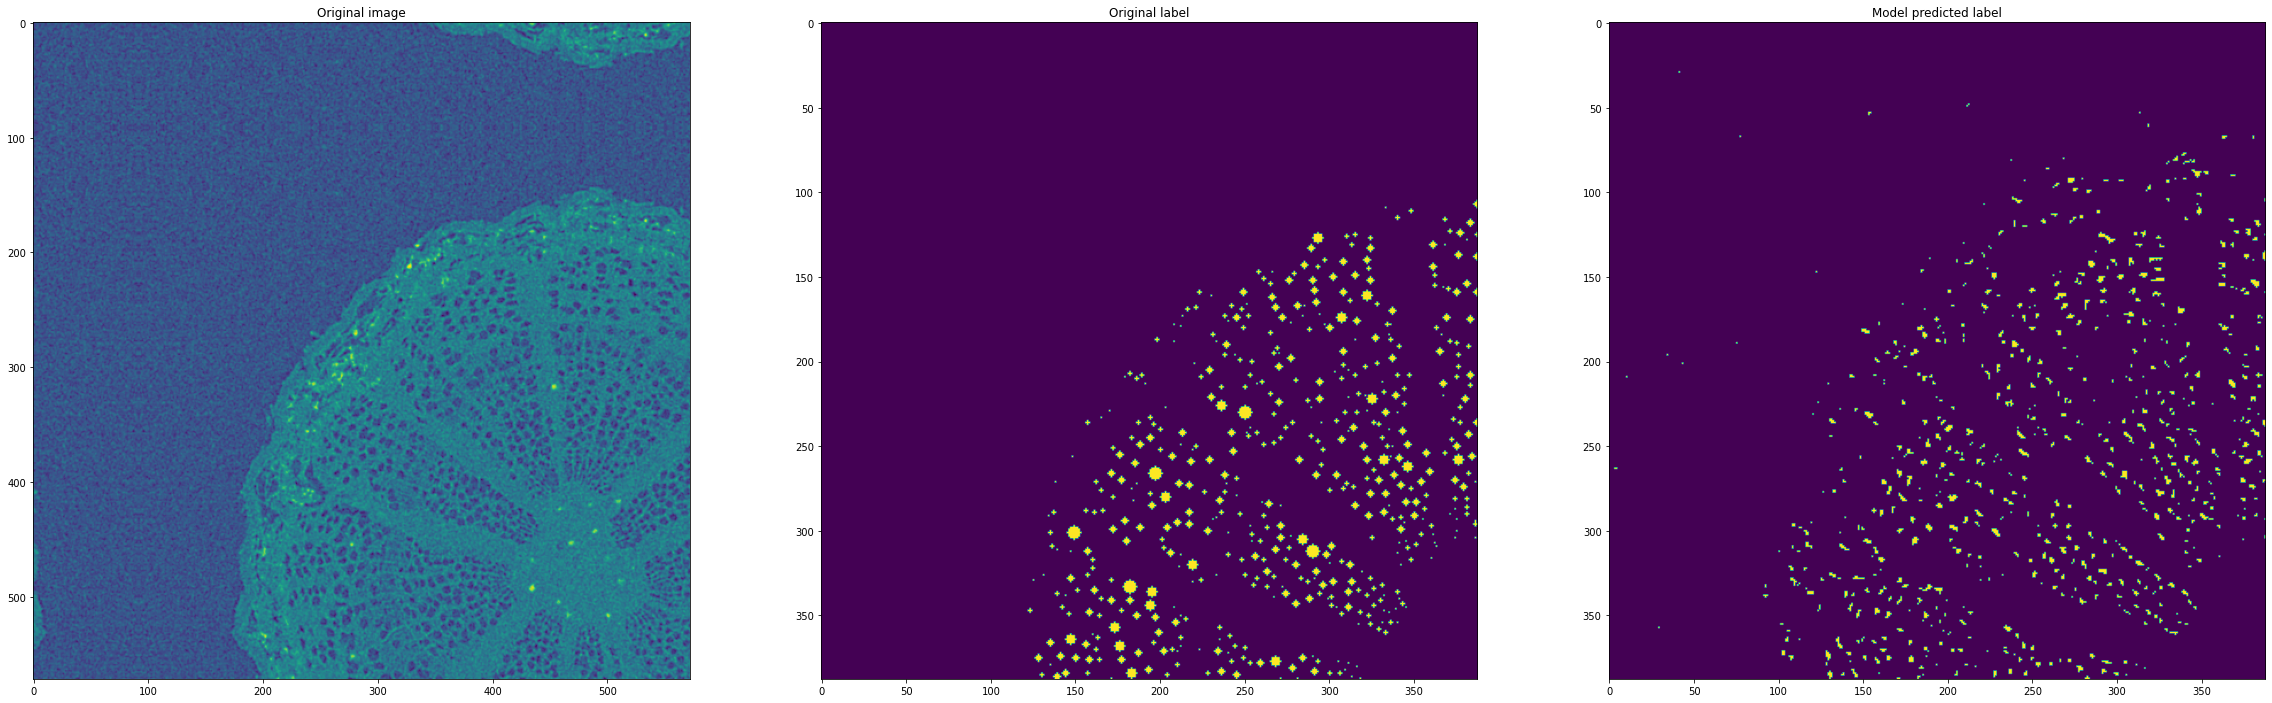

In [14]:
# Test a prediction
def make_prediction(model, test_img_pathname, test_label_pathname, test_seg_nb=0):
    test_img = cv.imread(test_img_pathname, cv.IMREAD_UNCHANGED) 
    test_label = png_to_mask(cv.imread(test_label_pathname, cv.IMREAD_UNCHANGED))
    test_image_segments, test_label_segments = segment_dataset([test_img], [test_label])
    test_img_seg = torch.tensor(test_image_segments[test_seg_nb, :, :], requires_grad=True).view(1, 1, 572, 572).to(device).float()
    test_label_seg = torch.tensor(test_label_segments[test_seg_nb, :, :].astype(float)).view(1, 388, 388).to(device).long()

    model.eval()
    test_pred = model(test_img_seg)
    test_pred = torch.argmax(test_pred, dim=1).cpu().detach().numpy()

    # Show predictions
    print(f"Output shape : {test_pred.shape}, max value={test_pred[0, :, :].max()}, min={test_pred[0, :, :].min()}, avg={test_pred.mean()}")

    _ , axs = plt.subplots(ncols=3, figsize=(40, 40))

    axs[0].set_title("Original image")
    test_img_seg = test_img_seg.cpu().detach().numpy()[0,0,:,:]
    axs[0].imshow(test_img_seg)

    axs[1].set_title("Original label")
    test_label_seg = test_label_seg.cpu().detach().numpy()[0,:,:]
    axs[1].imshow(test_label_seg)

    axs[2].set_title("Model predicted label")
    test_pred = test_pred[0, :, :]
    axs[2].imshow(test_pred)

    test_label_seg = test_label_seg.astype(int)

    emb_surf_pred_error = compute_emb_surf_pred_error(test_label_seg, test_pred, print_values=True)
    print(f"Emb surf pred err={emb_surf_pred_error}% (target is 0%)")
    print(f"Confusion values are :{confusion(test_label_seg, test_pred, data_type='numpy')}")

    plt.show()
    return

test_img_nb = 0
test_seg_nb = 0
make_prediction(model, imgs_names[test_img_nb], labels_names[test_img_nb], test_seg_nb)

In [ ]:
# Saving the model
print(f"Remember to set a model name that makes it easy to identify")
print(f"Here are the notebook parameters : \ncriterion={criterion} \noptimizer={optimizer} \nlr={learning_rate}, \nepochs={num_epochs}")
model_name = "PlaceHolder"
model_description = model_name + ""
PATH = "/content/drive/MyDrive/savedmodels/" + model_name + ".pkl"

print("\nmodel_name = " + model_name)
print("model_description = " + model_description)
print("PATH = " + PATH)

In [79]:
# Only save once name and descriptions are perfect
torch.save({
            'name': model_name,
            'description': model_description,
            'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(), # Only needed when planning to resume training from loaded model
            }, PATH)